####**OpenCV Darknet Yolo를 이용하여 이미지 Object Detection**
* yolo와 tiny-yolo를 이용하여 Object Detection

##### 입력 이미지로 사용될 이미지 다운로드/보기

In [1]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2021-10-19 13:14:35--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.01s   

2021-10-19 13:14:35 (28.8 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



##### Darknet Yolo사이트에서 coco로 학습된 Inference모델과 환결파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성

In [2]:
### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드하여 /content/pretrained 디렉토리 아래에 저장. 
!mkdir ./pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget -O /content/pretrained/yolov3.weights https://pjreddie.com/media/files/yolov3.weights
!wget -O /content/pretrained/yolov3.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true 

!wget -O /content/pretrained/yolov3-tiny.weights https://pjreddie.com/media/files/yolov3-tiny.weights
!wget -O /content/pretrained/yolov3-tiny.cfg https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true

!ls /content/pretrained

##### downloading pretrained yolo/tiny-yolo weight file and config file
--2021-10-19 13:15:21--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/content/pretrained/yolov3.weights’

/content/pretrained 100%[===================>] 236.52M  19.5MB/s    in 12s     

2021-10-19 13:15:34 (19.0 MB/s) - ‘/content/pretrained/yolov3.weights’ saved [248007048/248007048]

--2021-10-19 13:15:34--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2021-10-19 13:15:34--  https://github.com/p

readNetFromDarknet(config파일, weight파일)을 이용하여 yolo inference network모델을 로딩

In [3]:
import os
import cv2
weight_path='/content/pretrained/yolov3.weights'
config_path='/content/pretrained/yolov3.cfg'

cv_net_yolo=cv2.dnn.readNetFromDarknet(config_path,weight_path)

##### COCO class id와 class 명 매핑

In [4]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

##### 3개의 scale Output layer에서 결과 데이터 추출

In [12]:
layer_names=cv_net_yolo.getLayerNames()
print('### yolo v3 layer name:',layer_names)
print('final output layer id:',cv_net_yolo.getUnconnectedOutLayers())
print('final output layer name:',[layer_names[i[0]-1] for i in cv_net_yolo.getUnconnectedOutLayers()])


### yolo v3 layer name: ['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37',

In [13]:
#전체 Darknet layer에서 13x13 grid,28x28, 52x52 grid에서 detect된 Output layer만 filtering
layer_names=cv_net_yolo.getLayerNames()
outlayer_names=[layer_names[i[0]-1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('output_layer name:',outlayer_names)

img=cv2.imread('/content/data/beatles01.jpg')

cv_net_yolo.setInput(cv2.dnn.blobFromImage(img,scalefactor=1/255.0,size=(416,416),swapRB=True,crop=False))

cv_outs=cv_net_yolo.forward(outlayer_names)
print('cv_out type:',type(cv_outs),'cv_outs의 내부 원소 개수:',len(cv_outs))
print(cv_outs[0].shape,cv_outs[1].shape,cv_outs[2].shape)
print(cv_outs)

output_layer name: ['yolo_82', 'yolo_94', 'yolo_106']
cv_out type: <class 'list'> cv_outs의 내부 원소 개수: 3
(507, 85) (2028, 85) (8112, 85)
[array([[0.03803749, 0.0470234 , 0.3876816 , ..., 0.        , 0.        ,
        0.        ],
       [0.04705836, 0.03385845, 0.2689603 , ..., 0.        , 0.        ,
        0.        ],
       [0.04941482, 0.03791986, 0.7151826 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.9585798 , 0.9460585 , 0.35046625, ..., 0.        , 0.        ,
        0.        ],
       [0.96015006, 0.9630715 , 0.29724196, ..., 0.        , 0.        ,
        0.        ],
       [0.9663636 , 0.9657401 , 0.79356086, ..., 0.        , 0.        ,
        0.        ]], dtype=float32), array([[0.01637367, 0.02457962, 0.04684627, ..., 0.        , 0.        ,
        0.        ],
       [0.01678773, 0.01458679, 0.46203217, ..., 0.        , 0.        ,
        0.        ],
       [0.02219823, 0.01376948, 0.0662718 , ..., 0.        , 0.        ,
        0.

##### 3개의 scale output layer에서 Object Detection 정보를 모두 수집

In [19]:
import numpy as np

rows=img.shape[0]
cols=img.shape[1]

conf_threshold=0.5
nms_threshold=0.4

green_color=(0,255,0)
red_color=(0,0,255)

class_ids=[]
confidences=[]
boxes=[]

for ix,output in enumerate(cv_outs):
  print('output shape:',output.shape)
  for jx,detection in enumerate(output):
    class_score=detection[5:]
    class_id=np.argmax(class_score)
    confidence=class_score[class_id]

    if confidence > conf_threshold:
      print('ix:',ix,'jx:',jx,'class_id:',class_id,'confidence:',confidence)

      center_x=int(detection[0]*cols)
      center_y=int(detection[1]*rows)
      width=int(detection[2]*cols)
      height=int(detection[3]*rows)
      left=int(center_x-width/2)
      top=int(center_y-height/2)

      class_ids.append(class_id)
      confidences.append(float(confidence))
      boxes.append([left,top,width,height])

output shape: (507, 85)
ix: 0 jx: 319 class_id: 0 confidence: 0.9317017
ix: 0 jx: 328 class_id: 0 confidence: 0.96232384
ix: 0 jx: 334 class_id: 0 confidence: 0.9984486
ix: 0 jx: 343 class_id: 0 confidence: 0.9978433
output shape: (2028, 85)
ix: 1 jx: 831 class_id: 2 confidence: 0.8169964
ix: 1 jx: 955 class_id: 2 confidence: 0.8472691
ix: 1 jx: 1262 class_id: 0 confidence: 0.9877816
ix: 1 jx: 1280 class_id: 0 confidence: 0.99840033
ix: 1 jx: 1295 class_id: 0 confidence: 0.6916561
ix: 1 jx: 1313 class_id: 0 confidence: 0.9205806
output shape: (8112, 85)
ix: 2 jx: 2883 class_id: 2 confidence: 0.9077368
ix: 2 jx: 2886 class_id: 2 confidence: 0.63324535
ix: 2 jx: 3048 class_id: 2 confidence: 0.9412014
ix: 2 jx: 3051 class_id: 2 confidence: 0.615405
ix: 2 jx: 3184 class_id: 2 confidence: 0.95041
ix: 2 jx: 3214 class_id: 2 confidence: 0.9064125
ix: 2 jx: 3373 class_id: 2 confidence: 0.68998003
ix: 2 jx: 3394 class_id: 0 confidence: 0.76407045


##### NMS를 이용하여 각 Output layer에서 Detected된 Object의 겹치는 Bounding box를 제외

In [20]:
conf_threshold=0.5
nms_threshold=0.4
idxs=cv2.dnn.NMSBoxes(boxes,confidences,conf_threshold,nms_threshold)

In [23]:
idxs.flatten()

array([ 2,  7,  3,  6, 14, 12, 10, 15,  5,  4, 17, 16, 11, 13],
      dtype=int32)

##### NMS로 최종 filtering된 idxs를 이용하여 boxes,classes, confidences에서 해당하는 Object정보를 추출하고 시각화

person:0.9984
person:0.9984
person:0.9978
person:0.9878
car:0.9504
car:0.9412
car:0.9077
car:0.9064
car:0.8473
car:0.8170
person:0.7641
car:0.6900
car:0.6332
car:0.6154


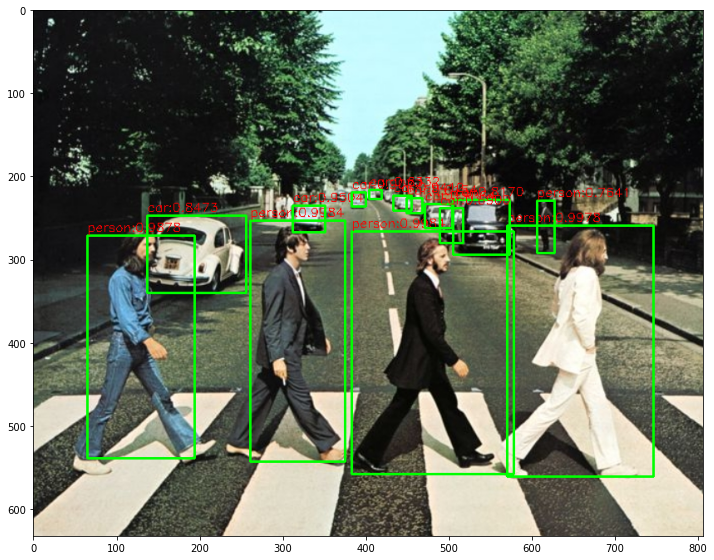

In [30]:
import matplotlib.pyplot as plt

draw_img=img.copy()

if len(idxs) >0:
  for i in idxs.flatten():
    box=boxes[i]
    left=box[0]
    top=box[1]
    right=box[0]+box[2]
    bottom=box[1]+box[3]

    caption="{}:{:.4f}".format(labels_to_names_seq[class_ids[i]],confidences[i])
    cv2.rectangle(draw_img,(left,top),(right,bottom),color=green_color,thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1)

    print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)